# Автокоректор помилок на Python

На основі блокнота Пітера Норвіга, Google

Переклад і доповнення: Жарчинський Станіслав

In [1]:
# імпортуй і володарюй
%pylab inline
import re
import math
from collections import Counter
import requests

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Дані: Текст і слова
Перш ніж щось робити зі словами (редагувати помилки, наприклад), треба ці слова звідкись взяти. Прийдеться знайти якийсь текст, можливо - з файлу, а можливо - десь на просторах інтернету. Потім цей текст розбити на слова. Ми запозичимо текст у Пітера Норвіга - автора одного з дуже популярних алгоритмів перевірки правопису (і директора з досліджень Google) :) [Ось текст.](https://norvig.com/big.txt) Зчитуємо його з інтернету та подивимося, наскільки фрагмент тексту великий (у кількості символів):

In [2]:
TEXT = requests.get('https://norvig.com/big.txt').text
len(TEXT)

6488666

Текст величезний – понад 6.5 млн. символів.

Тепер потрібно розбити текст на слова (Ну, або якщо бути трохи формальнішим, токени). Поки що ми не сильно замислюватимемося про те, що в тексті є пунктуація, цифри та інші символи - зосередимося тільки на словах, що складаються з літер.

In [3]:
def tokens(text):
    """Повертає список токенів (йдущих підряд буквених послідовностей) у тексті. 
    Текст переводиться до нижнього регістру."""
    return re.findall(r'[a-z]+', text.lower()) 

In [4]:
tokens('This is: A test, 1, 2, 3, this is.')

['this', 'is', 'a', 'test', 'this', 'is']

In [6]:
WORDS = tokens(TEXT)
len(WORDS)

1105285

Залишився мільйон слів. Ось перші 10:

In [7]:
print(WORDS[:10])

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes']


# (2) Модель: Мішок слів (aka Bag of Words)

Ми створили список WORDS - список слів у тому порядку, як вони йдуть у TEXT. Ми можемо використовувати цей список як породжувальну модель (generative model) тексту. Мова – дуже складна штука і ми створюємо вкрай спрощену модель мови, яка може схопити частину цієї складної структури. У моделі мішка слів ми повністю ігноруємо порядок слів, зате дотримуємося їх частоти. Уявити це можна так: ви берете всі слова тексту і закидаєте їх у мішок. Тепер, якщо ви хочете згенерувати пропозицію за допомогою цього мішка, ви просто трясете його (слова там перемішуються) і дістаєте вказану кількість слів по одному (мішок непрозорий, так що слова ви дістаєте навмання). Майже напевно отримана пропозиція буде граматично некоректною, але слова в цьому реченні будуть у +- правильної пропорції (частіші будуть зустрічатися частіше, рідкісні - рідше). Ось функція, яка семплює(від англ. sample) пропозицію з n слів за допомогою нашого мішка:

In [8]:
def sample(bag, n=10):
    "Sample a random n-word sentence from the model described by the bag of words."
    return ' '.join(random.choice(bag) for _ in range(n))

In [10]:
sample(WORDS)

'they english merely agree and neck countess only rode had'

Інший вигляд мішка слів - Counter. Це словник, що складається з пар {'слово': к-сть входжень слова в текст}. Наприклад,

In [11]:
Counter(tokens('Is this a test? It is a test!'))

Counter({'is': 2, 'this': 1, 'a': 2, 'test': 2, 'it': 1})

Counter дуже схожий на словник Python - тип dict , але він має ряд додаткових методів. Давайте загорнемо в Counter наш список слів WORDS і подивимося, що вийде:

In [13]:
COUNTS = Counter(WORDS)

print(COUNTS.most_common(10))

[('the', 80030), ('of', 40025), ('and', 38313), ('to', 28766), ('in', 22050), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


In [14]:
for w in tokens('the rare and neverbeforeseen words'):
    print(COUNTS[w], w)

80030 the
83 rare
38313 and
0 neverbeforeseen
460 words


In [15]:
len(COUNTS)

29157

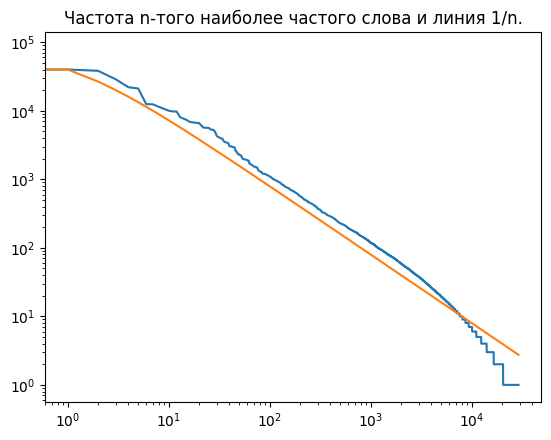

In [16]:
M = COUNTS['the']
yscale('log'); 
xscale('log'); 
title('Частота n-того найбільш частого слова та лінія 1/n.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)]);

# (3) Завдання: Перевірка Правопису